(computing-derivatives)=
# 3.2 Computing Derivatives of Functions
In the lecture, we learned different ways to calculate the derivative of a function:
- finite differences
    - forward difference
    - central difference
- automatic differentiation (AD)
    - forward mode
    - reverse mode

A good explanation for the error in estimating derivatives and automatic differentiation can be found here: https://book.sciml.ai/notes/08-Forward-Mode_Automatic_Differentiation_(AD)_via_High_Dimensional_Algebras/
Some parts of this exercise are based on these lecture notes.

(finite-differences)=
## Finite Differences - Differenzenquotient
The derivative of a function $f(x)$ can be approximated by the finite differences:

$$
\frac{d f}{d x} \approx \frac{f(x + \Delta x) - f(x)}{\Delta x}
$$

This is called the forward difference. We can also use the central difference:

$$
\frac{d f}{d x} \approx \frac{f(x + \Delta x) - f(x - \Delta x)}{2 \Delta x}
$$

In the lecture we already discussed that the step size $\Delta x$ has a big influence on the error of the approximation. We want to investigate this influence and visualize the error for different step sizes $\Delta x$. What is the smallest number we can use for $\Delta x$? What happens if we use such a small number? What happens if we use a larger number? First lets check our machine precision $\epsilon$:

In [ ]:
import Pkg
Pkg.instantiate()

In [1]:
prec = eps(Float64)

2.220446049250313e-16

What does this number tell us? Since floating point numbers are scaled there is a limit to the precision of the numbers we want to represent and perform operations with. This is however relative to the size of the number:

In [2]:
@show eps(1.0)
@show eps(0.1)
@show eps(0.01)

eps(1.0) = 2.220446049250313e-16
eps(0.1) = 1.3877787807814457e-17
eps(0.01) = 1.734723475976807e-18


1.734723475976807e-18

As we have seen in the lecture this can be a problem if we substract numbers that are close to each other. Let's check this again:

In [3]:
ϵ = 1e-10rand()
@show ϵ
@show (1+ϵ)
ϵ2 = (1+ϵ) - 1
(ϵ - ϵ2)

ϵ = 1.1349946372077903e-11
1 + ϵ = 1.00000000001135


-8.565326999780176e-17

By adding 1 to the small random number we lose the information of the last digits of the small number. When we substract 1 again we don't get the same number back. Hence, we have a loss of precision.

Ok, so now we want to see how this influence our finite differences approach. We learned that $\sqrt{\epsilon}$ is a good choice for $\Delta x$. In general we cannot expect a lower errer than approximately $\sqrt{\epsilon} \approx 10^{-8}$.

In [4]:
@show sqrt(eps(Float64))

sqrt(eps(Float64)) = 1.4901161193847656e-8


1.4901161193847656e-8

We use $\Delta x = 2.3*10^{-16}$ as the smallest number. For the largest number we use $\Delta x = 0.1$. Let's plot the error for different step sizes $\Delta x$.

Write a function which takes the function $f(x)$, a value for $x$, and a vector of step sizes $\Delta x$ and returns the forward and central differences of $f(x)$ at $x$ for the different step sizes $\Delta x$.

In [5]:
function FiniteDifferenceMethod(x::Real, our_eps::Vector, f::Function)
    forward = (f.(x.+our_eps) .- f.(x)) ./ our_eps
    central = (f.(x.+our_eps) .- f.(x.-our_eps)) ./ (2*our_eps)
    forward, central
end

FiniteDifferenceMethod (generic function with 1 method)

Plot the error of the the forward and central difference for the function $f(x) = x^2+sin(x)$ and for different step sizes $\Delta x$ from $0.1$ to $10^{-16}$.

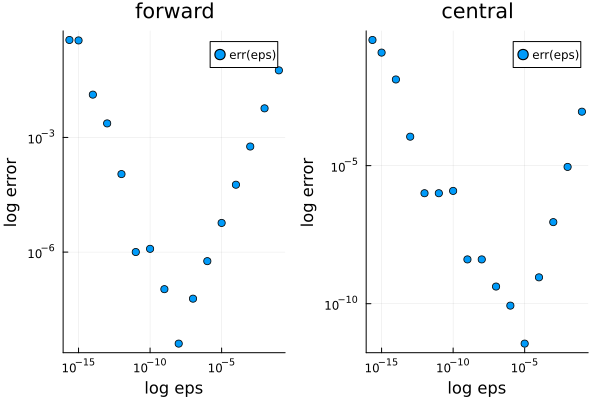

In [6]:
import Plots
using LinearAlgebra
f(x) = x^2+sin(x)
df(x) = 2*x+cos(x) # analytical derivative of f to estimate the error

eps_length = 16
eps_range = 10 .^ -range(1, stop=16, length=eps_length)
eps_range[eps_length] = 2.3*10^-16 # set the last element to 2.3e-16
x = 1.0
real_dfx = df(x)
df_forw_eps, df_cent_eps = FiniteDifferenceMethod(x, eps_range, f)
error_forward = abs.(df_forw_eps.-real_dfx)
error_central = abs.(df_cent_eps.-real_dfx)

p1 = Plots.scatter(eps_range, error_forward, label="err(eps)" , title="forward", xlabel="log eps", ylabel="log error", xscale=:log10, yscale=:log10)
p2= Plots.scatter(eps_range, error_central, label="err(eps)" , title="central", xlabel="log eps", ylabel="log error", xscale=:log10, yscale=:log10)
Plots.plot(p1, p2)

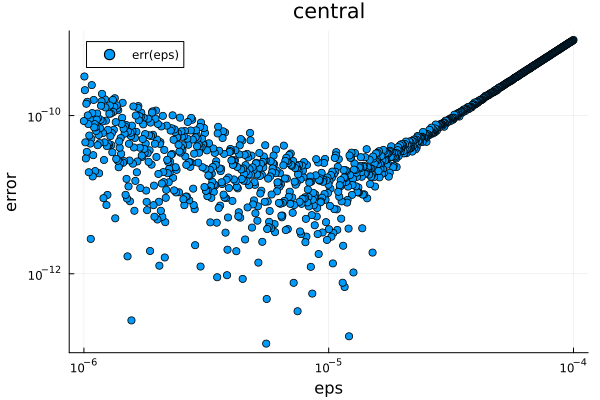

In [7]:
eps_range = 10 .^ -range(4, stop=6, length=1000)
df_fd_eps, df_cd_eps = FiniteDifferenceMethod(x, eps_range, f)

p3 = Plots.scatter(eps_range, abs.(df_cd_eps.-real_dfx), label="err(eps)" , title="central", xlabel="eps", ylabel="error", xscale=:log10, yscale=:log10)

### Derivatives of a function with multiple variables with finite differences
We have learned that the partial derivative of a function $f(x,y)$ with respect to $x$ is estimated by keeping $y$ constant and vice versa. We can use this approach to estimate the partial derivative using finite differences. Since the gradient of a function $f(x,y)$ is defined as:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x}, \frac{\partial f}{\partial y}
\end{bmatrix}
$$

We can estimate the gradient with the partial derivative for each variable seperately.

Let's try this for the function $f(x, y) = x^2 + x*y$.

In [8]:
f(x,y)=x^2+x*y
a, b = 1.0, 1.0 # We want to estimate the partial derivatives of f at (a,b)

f_x(x) = f(x, b)
f_y(y) = f(a, y)

real_df_dx = 2*a+b
real_df_dy = a

df_dx_f_c = FiniteDifferenceMethod(a, [10^-8], f_x)
df_dy_f_c = FiniteDifferenceMethod(b, [10^-8], f_y)
df_dx = df_dx_f_c[2][1]
df_dy = df_dy_f_c[2][1]
@show grad_f = [df_dx, df_dy]
@show real_grad_f = [real_df_dx, real_df_dy];

grad_f = [df_dx, df_dy] = [2.9999999928698173, 0.999999993922529]
real_grad_f = [real_df_dx, real_df_dy] = [3.0, 1.0]


If we have another equation $g(x,y) = x^2 + y^2$ we can calculate the total derivative of the system of equations $f(x,y)$ and $g(x,y)$ with respect to $x$ and $y$ which is the Jacobian matrix:

$$
\mathbf{J} = \begin{bmatrix}
\nabla f \\
 \nabla g
\end{bmatrix} = \begin{bmatrix}
\frac{\partial f}{\partial x} & \frac{\partial f}{\partial y} \\
\frac{\partial g}{\partial x} & \frac{\partial g}{\partial y}
\end{bmatrix} 
$$

In [9]:
g(x,y) = x^2 + y^2

g_x(x) = g(x, b)
g_y(y) = g(a, y)

real_dg_dx = 2*a
real_dg_dy = 2*b

dg_dx_f_c = FiniteDifferenceMethod(a, [10^-8], g_x)
dg_dy_f_c = FiniteDifferenceMethod(b, [10^-8], g_y)
dg_dx = dg_dx_f_c[2][1]
dg_dy = dg_dy_f_c[2][1]
@show grad_g = [dg_dx, dg_dy]
@show real_grad_g = [real_dg_dx, real_dg_dy]
@show jacobian_f = [df_dx df_dy; dg_dx dg_dy];

grad_g = [dg_dx, dg_dy] = [1.999999987845058, 1.999999987845058]
real_grad_g = [real_dg_dx, real_dg_dy] = [2.0, 2.0]
jacobian_f = [df_dx df_dy; dg_dx dg_dy] = [2.9999999928698173 0.999999993922529; 1.999999987845058 1.999999987845058]


We used an inefficient way to calculate the Jacobian. We needed to calculate the partial derivative of each function with respect to each variable. There are more efficient ways to calculate the Jacobian matrix like using colored Jacobians or automatic differentiation (next section).

In practice you can use FiniteDifferences.jl to calculate the Jacobian matrix using finite differences. This package can be installed with `Pkg.add("FiniteDifferences")`. 
Let's try this out for the function 

$$
\mathbf{f(x)} =  \begin{bmatrix}
x_1^2 + x_1*x_2 \\
x_1^2 + x_2^2
\end{bmatrix} 
$$. 

We can use the function `jacobian` from the package FiniteDifferences.jl to calculate the Jacobian matrix:

In [17]:
# import Pkg;
# Pkg.add("FiniteDifferences");
import FiniteDifferences

f(x) = [x[1]^2+x[1]*x[2]; 
        x[1]^2+x[2]^2]
x = [1.0, 1.0]

J = FiniteDifferences.jacobian(FiniteDifferences.central_fdm(2, 1), f, x)[1]
@show J

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


J = [2.9999999971973947 0.9999999990657983; 1.9999999981315966 1.9999999981315966]


2×2 Matrix{Float64}:
 3.0  1.0
 2.0  2.0

(automatic-differentiation)=
## Automatic Differentiation (AD)
Automatic Differentiation (AD) is a set of techniques to numerically evaluate the derivative of a function. AD is generally more accurate than the finite differences based numerical differentiation we used above. In the lecture we have seen two different methods of AD: the forward mode and the reverse mode (Backpropagation).

(forward-mode)=
### Forward Mode
You have seen in the lecture that the forward mode AD makes use of dual numbers to calculate the derivative of a function. For each value $x$ we create a dual number $x + \epsilon x'$ where $\epsilon$ is a small number and $x'$ is the derivative of $x$. We can use the dual number to calculate the derivative of a function $f(x)$:

$$
f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2)
$$

As discussed in the lecture we defined $\epsilon^2 = 0$ and got:

$$
f(x + \epsilon) = f(x) + \epsilon f'(x)
$$

To use this in practice we have to implement $f(x)$ to support our dual numbers for each function we want to calculate the derivative. Hence, we have to implement what happens with the derivative $f'(x)$ for each operation we want to support. For example, for the addition of two dual numbers $x + \epsilon x'$ and $y + \epsilon y'$ we get:

$$
(x + \epsilon x') + (y + \epsilon y') = (x + y) + \epsilon (x' + y')
$$ 

We can see that the derivative of the addition is the addition of the derivatives. We can implement this in Julia by overloading the addition operator `+` for dual numbers. We can do this similarly for the other operations.

We can use the package `ForwardDiff.jl` to do this for us. Let's try this out for the function $f(x) = x^2 + sin(x)$. We can use the function `ForwardDiff.derivative` to calculate the derivative of $f(x)$ at $x$:

In [12]:
import ForwardDiff
f(x) = x^2+sin(x)
df(x) = 2*x+cos(x) # analytical derivative of f to estimate the error

@show ForwardDiff.derivative(f, 1.0)
@show df(1.0);

ForwardDiff.derivative(f, 1.0) = 2.5403023058681398
df(1.0) = 2.5403023058681398


We can calculate the gradient of a function $f(x,y)$ with respect to $x$ and $y$ using the function `ForwardDiff.gradient`:

In [13]:
f(x) = x[1]^2+x[1]*x[2]

@show ForwardDiff.gradient(f, [1.0, 1.0]);

ForwardDiff.gradient(f, [1.0, 1.0]) = [3.0, 1.0]


We can also calculate the Jacobian matrix using the function `jacobian` from `ForwardDiff`. This function takes a function as an argument and returns the Jacobian matrix of the function. Let's try this out for the function 

$$
\mathbf{f(x)} =  \begin{bmatrix}
x_1^2 + x_1*x_2 \\
x_1^2 + x_2^2
\end{bmatrix} 
$$

In [14]:
f(x) = [x[1]^2+x[1]*x[2]; 
        x[1]^2+x[2]^2]
x = [1.0, 1.0]

ForwardDiff.jacobian(f, x)

2×2 Matrix{Float64}:
 3.0  1.0
 2.0  2.0

(reverse-mode)=
### Reverse Mode
When we want to compute the gradient of a function $f(x)$ with respect to $x$ we have seen that we can use the forward mode AD. This is a good choice if we have a function $f(x)$ with a small number of variables. If we have a function $f(x)$ with a large number of variables the forward mode AD is not efficient. In this case we can use the reverse mode AD (backpropagation, adjoint technique). In the lecture we have seen that the reverse mode AD uses the chain rule to calculate the gradient of a function $f(x(z), y(z))$ with respect to $z$. We can write the chain rule as:

$$
\frac{\partial f}{\partial z} = \frac{\partial f}{\partial x} \frac{\partial x}{\partial z} + \frac{\partial f}{\partial y} \frac{\partial y}{\partial z}
$$

where $x, y$ are intermediate variables. We can use this to calculate the gradient of a function $f(x(z), y(z))$ with respect to $z$ by calculating the partial derivative of $f(x(z), y(z))$ with respect to each intermediate variable $x$ or $y$ and multiplying it with the partial derivative of $x$ or $y$ with respect to $z$. We can see that we have to calculate the partial derivative of $f$ with respect to each intermediate variable $x,y $ and the partial derivative of $x,y $ with respect to $z$. A popular example for the use of reverse mode AD is in deep learning to calculate the gradient of the loss function with respect to the weights of the neural network. In this case we have a large number of weights and often a scalar loss function. Hence, the reverse mode AD is a good choice. Now we want to take a look at the reverse mode AD in practice. We will use the package `ReverseDiff.jl` to do this. Let's try this out for the function $f(x_1, x_2) = x_1^2 + x_1*x_2$. 

If you are interested in the details of reverse mode AD you can have a look at the lecture slides again or find a good explanation here: https://book.sciml.ai/notes/10-Basic_Parameter_Estimation-Reverse-Mode_AD-and_Inverse_Problems/

In [18]:
# import Pkg;
# Pkg.add("ReverseDiff");
import ReverseDiff

f(x) = x[1]^2+x[1]*x[2]
ReverseDiff.gradient(f, [1.0, 1.0])

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


2-element Vector{Float64}:
 3.0
 1.0

In [16]:
f(x) = [x[1]^2+x[1]*x[2]; 
        x[1]^2+x[2]^2]
ReverseDiff.jacobian(f, [1.0, 1.0])

2×2 Matrix{Float64}:
 3.0  1.0
 2.0  2.0

We can see for the basic usage `ReverseDiff` and `ForwardDiff` are very similar. Which one you should use depends on the function you want to differentiate. It is very well summarized in https://book.sciml.ai: Forward mode computes columns of a Jacobian, while reverse mode computes gradients (rows of a Jacobian). Therefore, the relative efficiency of the two approaches is based on the size of the Jacobian. 
For $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$ with $n$ variables and $m$ functions the Jacobian is a $m \times n$ matrix. So computing each row will be much faster if $m$ is much smaller than $n$. Or in other words if the number of variables is larger than the number of functions, then reverse mode is more efficient. If the number of functions is larger than the number of variables, then forward mode is more efficient. If $m$ and $n$ are relatively equal forward mode is often more efficient since reverse mode has a high overhead compared to forward mode. If you are not sure which approach to use you can try both and benchmark the results.